# Test with fitto distributions

In [937]:
import numpy as np
import scipy as sp
from lbfgsb import minimize_lbfgsb
from pyrtid.utils import finite_gradient, NDArrayFloat, NDArrayInt
from numpy.typing import ArrayLike
import numdifftools as nd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

multimodal_dist_target = np.concatenate(
    (
        np.random.normal(10, 3, 1000),
        np.random.normal(30, 5, 4000),
        np.random.normal(45, 6, 500),
    ),
    axis=0,
)

multimodal_dist_init = np.concatenate(
    (
        np.random.normal(-10, 3, 50),
        np.random.normal(20, 5, 200),
        np.random.normal(60, 6, 25),
    ),
    axis=0,
)

dist_range = (
    min(np.min(multimodal_dist_target).item(), np.min(multimodal_dist_init).item()),
    max(np.max(multimodal_dist_target).item(), np.max(multimodal_dist_init).item()),
)

In [938]:
pv, bins_target = np.histogram(multimodal_dist_target, bins=50, range=dist_range)
v = (bins_target[:-1] + bins_target[1:]) / 2

pu, bins_init = np.histogram(multimodal_dist_init, bins=50, range=dist_range)
u = (bins_init[:-1] + bins_init[1:]) / 2

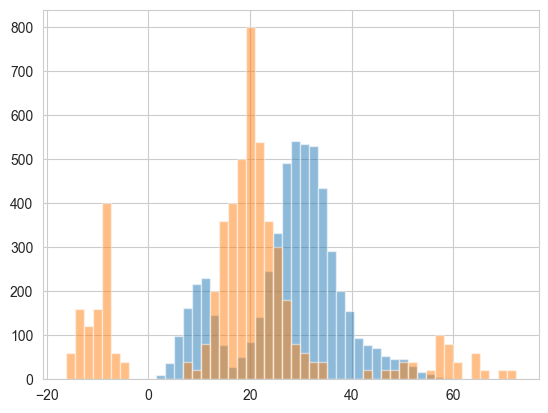

In [939]:
plt.hist(multimodal_dist_target, bins=50, alpha=0.5, range=dist_range)
plt.hist(
    multimodal_dist_init,
    bins=50,
    alpha=0.5,
    weights=np.ones_like(multimodal_dist_init) * 20.0,
    range=dist_range,
)
plt.show()

In [982]:
from typing import Tuple, Optional
from scipy.stats._stats_py import _validate_distribution
from scipy.sparse import csc_array, lil_array


def get_cdfs(
    u_values: ArrayLike,
    v_values: ArrayLike,
    u_weights: Optional[ArrayLike] = None,
    v_weights: Optional[ArrayLike] = None,
) -> Tuple[NDArrayFloat, NDArrayFloat, NDArrayFloat, NDArrayInt, NDArrayInt]:
    u_values, u_weights = _validate_distribution(u_values, u_weights)
    v_values, v_weights = _validate_distribution(v_values, v_weights)

    u_sorter = np.argsort(u_values)
    v_sorter = np.argsort(v_values)

    all_values = np.concatenate((u_values, v_values))
    all_sorter = np.argsort(all_values, kind="mergesort")
    all_values = all_values[all_sorter]

    # Compute the differences between pairs of successive values of u and v.
    deltas = np.diff(all_values)

    # Get the respective positions of the values of u and v among the values of
    # both distributions.
    u_cdf_indices = u_values[u_sorter].searchsorted(all_values[:-1], "right")
    v_cdf_indices = v_values[v_sorter].searchsorted(all_values[:-1], "right")

    # Calculate the CDFs of u and v using their weights, if specified.
    if u_weights is None:
        u_cdf = u_cdf_indices / u_values.size
    else:
        u_sorted_cumweights = np.concatenate(([0], np.cumsum(u_weights[u_sorter])))
        u_cdf = u_sorted_cumweights[u_cdf_indices] / u_sorted_cumweights[-1]

    if v_weights is None:
        v_cdf = v_cdf_indices / v_values.size
    else:
        v_sorted_cumweights = np.concatenate(([0], np.cumsum(v_weights[v_sorter])))
        v_cdf = v_sorted_cumweights[v_cdf_indices] / v_sorted_cumweights[-1]

    return u_cdf, v_cdf, deltas, u_cdf_indices, all_sorter


def cdf_distance(
    p: float,
    u_values: ArrayLike,
    v_values: ArrayLike,
    u_weights: Optional[ArrayLike] = None,
    v_weights: Optional[ArrayLike] = None,
) -> float:
    r"""
    Compute, between two one-dimensional distributions :math:`u` and
    :math:`v`, whose respective CDFs are :math:`U` and :math:`V`, the
    statistical distance that is defined as:

    .. math::

        l_p(u, v) = \left( \int_{-\infty}^{+\infty} |U-V|^p \right)^{1/p}

    p is a positive parameter; p = 1 gives the Wasserstein distance, p = 2
    gives the energy distance.

    Parameters
    ----------
    u_values, v_values : array_like
        Values observed in the (empirical) distribution.
    u_weights, v_weights : array_like, optional
        Weight for each value. If unspecified, each value is assigned the same
        weight.
        `u_weights` (resp. `v_weights`) must have the same length as
        `u_values` (resp. `v_values`). If the weight sum differs from 1, it
        must still be positive and finite so that the weights can be normalized
        to sum to 1.

    Returns
    -------
    distance : float
        The computed distance between the distributions.

    Notes
    -----
    The input distributions can be empirical, therefore coming from samples
    whose values are effectively inputs of the function, or they can be seen as
    generalized functions, in which case they are weighted sums of Dirac delta
    functions located at the specified values.

    References
    ----------
    .. [1] Bellemare, Danihelka, Dabney, Mohamed, Lakshminarayanan, Hoyer,
           Munos "The Cramer Distance as a Solution to Biased Wasserstein
           Gradients" (2017). :arXiv:`1705.10743`.

    """
    u_cdf, v_cdf, deltas, _, _ = get_cdfs(u_values, v_values, u_weights, v_weights)

    # Compute the value of the integral based on the CDFs.
    # If p = 1 or p = 2, we avoid using np.power, which introduces an overhead
    # of about 15%.
    if p == 1:
        return np.sum(np.multiply(np.abs(u_cdf - v_cdf), deltas))
    if p == 2:
        return np.sqrt(np.sum(np.multiply(np.square(u_cdf - v_cdf), deltas)))
    return np.power(
        np.sum(np.multiply(np.power(np.abs(u_cdf - v_cdf), p), deltas)), 1 / p
    )


def cdf_distance_gradient(
    p: float,
    u_values: ArrayLike,
    v_values: ArrayLike,
    u_weights: Optional[ArrayLike] = None,
    v_weights: Optional[ArrayLike] = None,
) -> NDArrayFloat:
    r"""
    Compute, between two one-dimensional distributions :math:`u` and
    :math:`v`, whose respective CDFs are :math:`U` and :math:`V`, the
    gradient with respect to :math:`u` of the statistical distance that is defined as:

    .. math::

        l_p(u, v) = \left( \int_{-\infty}^{+\infty} |U-V|^p \right)^{1/p}

    p is a positive parameter; p = 1 gives the Wasserstein distance, p = 2
    gives the energy distance.

    Parameters
    ----------
    u_values, v_values : array_like
        Values observed in the (empirical) distribution.
    u_weights, v_weights : array_like, optional
        Weight for each value. If unspecified, each value is assigned the same
        weight.
        `u_weights` (resp. `v_weights`) must have the same length as
        `u_values` (resp. `v_values`). If the weight sum differs from 1, it
        must still be positive and finite so that the weights can be normalized
        to sum to 1.

    Returns
    -------
    distance gradient : NDArrayFloat
        The computed distance between the distributions.

    Notes
    -----
    The input distributions can be empirical, therefore coming from samples
    whose values are effectively inputs of the function, or they can be seen as
    generalized functions, in which case they are weighted sums of Dirac delta
    functions located at the specified values.

    References
    ----------
    .. [1] Bellemare, Danihelka, Dabney, Mohamed, Lakshminarayanan, Hoyer,
           Munos "The Cramer Distance as a Solution to Biased Wasserstein
           Gradients" (2017). :arXiv:`1705.10743`.

    """
    u_cdf, v_cdf, deltas, u_cdf_indices, all_sorter = get_cdfs(
        u_values, v_values, u_weights, v_weights
    )

    # Note about the derivation => the derivative of u_cdf with respect to u_values
    # is always null (the order is preserved)
    # So the only term that matters in the derivation is the one with resepct to deltas
    if p == 1:
        _temp: NDArrayFloat = np.abs(u_cdf - v_cdf)
    elif p == 2:
        _temp = (
            0.5
            / np.sqrt(np.sum(np.multiply(np.square(u_cdf - v_cdf), deltas)))
            * np.square(u_cdf - v_cdf)
        )
    else:
        _temp = (
            1
            / p
            * np.power(
                np.sum(np.multiply(np.power(np.abs(u_cdf - v_cdf), p), deltas)),
                1 / p - 1,
            )
            * np.power(np.abs(u_cdf - v_cdf), p)
        )

    # First approach = more expensive because one needs to build J,
    # the derivatives of deltas with respect to the sorted u_values
    # it is a sparse matrix filled by 1 and -1
    # n = u_cdf_indices.size
    # J = sp.sparse.diags_array([-np.ones(n + 1), np.ones(n)], offsets=[0, 1]).tocsc()[
    #     :-1, np.argsort(all_sorter)
    # ][:, :np.size(u_values)]
    # convertion to csc for faster multiplication
    # return J.tocsc().T @ _temp

    # Second approach striclty equivalent but faster
    return (
        -np.concatenate([_temp, [0.0]], dtype=np.float64)[np.argsort(all_sorter)][
            : np.size(u_values)
        ]
        + np.concatenate([[0.0], _temp], dtype=np.float64)[np.argsort(all_sorter)][
            : np.size(u_values)
        ]
    )


def cost_fun_p1(x) -> float:
    return cdf_distance(1, x, v, None, pv) * 1e3


def cost_fun_grad_p1(x) -> NDArrayFloat:
    return cdf_distance_gradient(1, x, v, None, pv) * 1e3


def cost_fun_p2(x) -> float:
    return cdf_distance(2, x, v, None, pv) * 1e3


def cost_fun_grad_p2(x) -> NDArrayFloat:
    return cdf_distance_gradient(2, x, v, None, pv) * 1e3


def cost_fun_p3(x) -> float:
    return cdf_distance(3, x, v, None, pv) * 1e5


def cost_fun_grad_p3(x) -> NDArrayFloat:
    return cdf_distance_gradient(3, x, v, None, pv) * 1e5

In [941]:
cdf_distance(1, u, u, pu, pu)

0.0

In [942]:
cdf_distance(1, u, v, pu, pv)

11.908526472154904

In [943]:
cdf_distance(1, multimodal_dist_init, multimodal_dist_target, None, None)

11.973421989225379

In [944]:
cdf_distance(1, multimodal_dist_init, v, None, pv)

11.969297088169188

In [945]:
cost_fun_p1(multimodal_dist_init)

11969.297088169189

In [946]:
cost_fun_grad_p1(multimodal_dist_init)

array([-3.63636364, -3.63636364, -3.63636364, -3.63636364, -3.63636364,
       -3.63636364, -3.63636364, -3.63636364, -3.63636364, -3.63636364,
       -3.63636364, -3.63636364, -3.63636364, -3.63636364, -3.63636364,
       -3.63636364, -3.63636364, -3.63636364, -3.63636364, -3.63636364,
       -3.63636364, -3.63636364, -3.63636364, -3.63636364, -3.63636364,
       -3.63636364, -3.63636364, -3.63636364, -3.63636364, -3.63636364,
       -3.63636364, -3.63636364, -3.63636364, -3.63636364, -3.63636364,
       -3.63636364, -3.63636364, -3.63636364, -3.63636364, -3.63636364,
       -3.63636364, -3.63636364, -3.63636364, -3.63636364, -3.63636364,
       -3.63636364, -3.63636364, -3.63636364, -3.63636364, -3.63636364,
       -3.63636364, -3.63636364, -3.63636364, -3.63636364, -3.63636364,
       -3.63636364, -3.63636364, -3.63636364, -3.63636364, -3.63636364,
       -3.63636364, -3.63636364, -3.63636364, -3.63636364, -3.63636364,
       -3.63636364, -3.63636364, -3.63636364, -3.63636364, -3.63

In [947]:
res_p1 = minimize_lbfgsb(
    x0=multimodal_dist_init, fun=cost_fun_p1, jac=cost_fun_grad_p1, maxiter=20
)

In [948]:
res_p1

  message: STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
  success: True
   status: 1
      fun: 112.07059847916702
        x: [ 9.384e+00  1.299e+01 ...  4.493e+01  3.454e+01]
      nit: 20
      jac: [-3.636e+00  3.636e+00 ...  3.636e+00  2.545e+00]
     nfev: 34
     njev: 34
 hess_inv: <275x275 LbfgsInvHessProduct with dtype=float64>

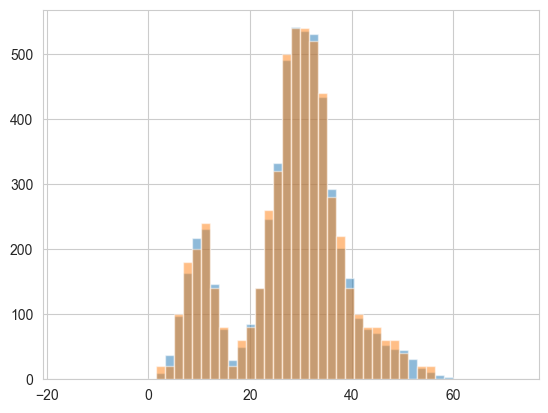

In [950]:
plt.hist(multimodal_dist_target, bins=50, alpha=0.5, range=dist_range)
plt.hist(
    res_p1.x,
    bins=50,
    alpha=0.5,
    range=dist_range,
    weights=np.ones_like(res_p1.x) * 20.0,
)
plt.show()

In [951]:
grad_fd_p1 = finite_gradient(x=multimodal_dist_init, fm=cost_fun_p1)

In [952]:
grad_fd_p2 = finite_gradient(x=multimodal_dist_init, fm=cost_fun_p2)

In [953]:
grad_fd_p3 = finite_gradient(x=multimodal_dist_init, fm=cost_fun_p3)

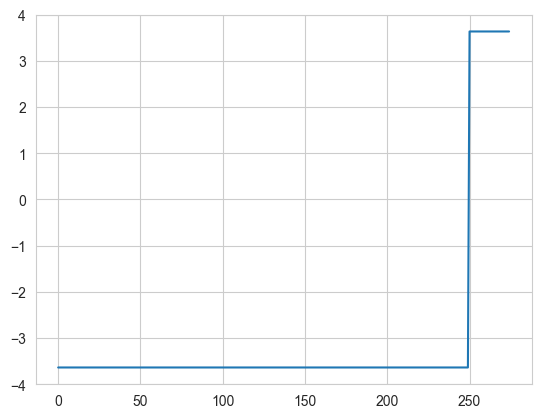

In [954]:
plt.plot(grad_fd_p1)

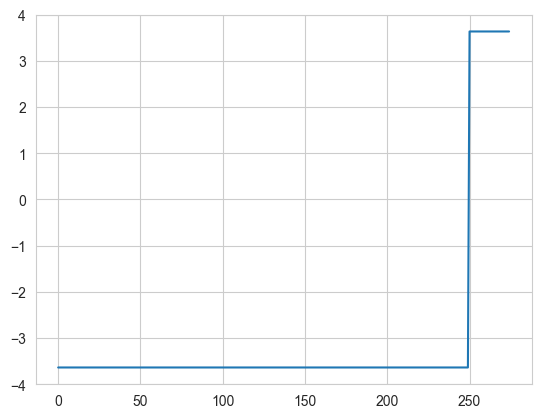

In [956]:
plt.plot(cost_fun_grad_p1(multimodal_dist_init))

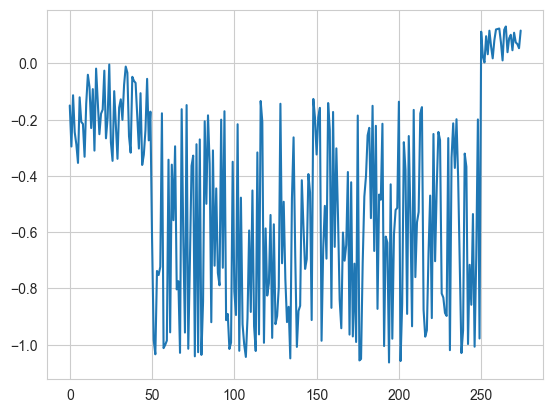

In [957]:
plt.plot(grad_fd_p2)

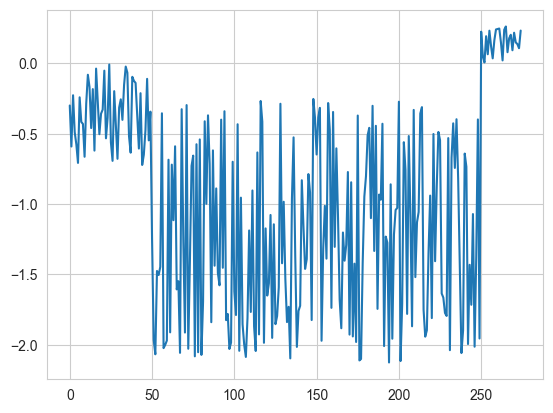

In [958]:
plt.plot(cost_fun_grad_p2(multimodal_dist_init))

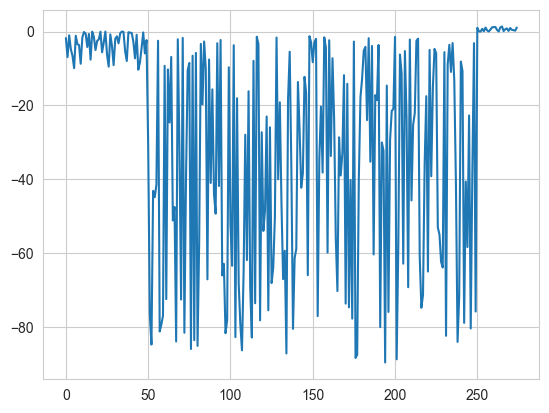

In [959]:
plt.plot(grad_fd_p3)

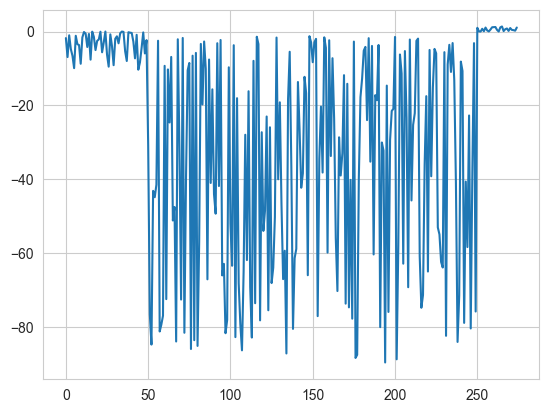

In [960]:
plt.plot(cost_fun_grad_p3(multimodal_dist_init))

In [961]:
res_p2 = minimize_lbfgsb(
    x0=multimodal_dist_init, fun=cost_fun_p2, jac=cost_fun_grad_p2, maxiter=20
)

In [962]:
res_p2

  message: STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
  success: True
   status: 1
      fun: 119.92505645707021
        x: [ 1.064e+01  2.845e+01 ...  4.785e+01  4.054e+01]
      nit: 20
      jac: [-4.410e-02 -1.036e+00 ... -1.103e-01  3.859e-01]
     nfev: 28
     njev: 28
 hess_inv: <275x275 LbfgsInvHessProduct with dtype=float64>

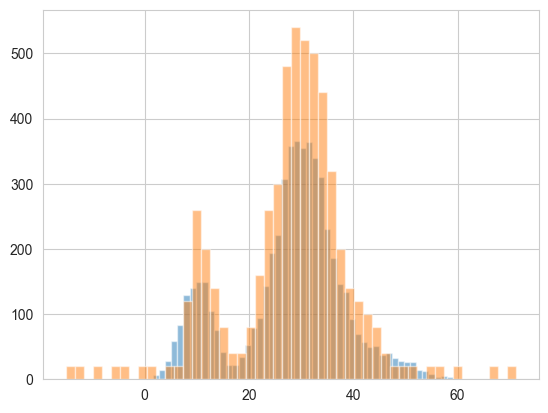

In [965]:
plt.hist(multimodal_dist_target, bins=50, alpha=0.5)
plt.hist(res_p2.x, bins=50, alpha=0.5, weights=np.ones_like(res_p1.x) * 20.0)
plt.show()

In [966]:
res_p3 = minimize_lbfgsb(
    x0=multimodal_dist_init, fun=cost_fun_p3, jac=cost_fun_grad_p3, maxiter=20
)

In [967]:
res_p3

  message: STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
  success: True
   status: 1
      fun: 9734.52558052304
        x: [ 1.805e+01  1.153e+01 ...  5.281e+01  3.833e+01]
      nit: 20
      jac: [ 4.763e+00  1.457e+01 ...  1.596e+01 -3.875e-15]
     nfev: 29
     njev: 29
 hess_inv: <275x275 LbfgsInvHessProduct with dtype=float64>

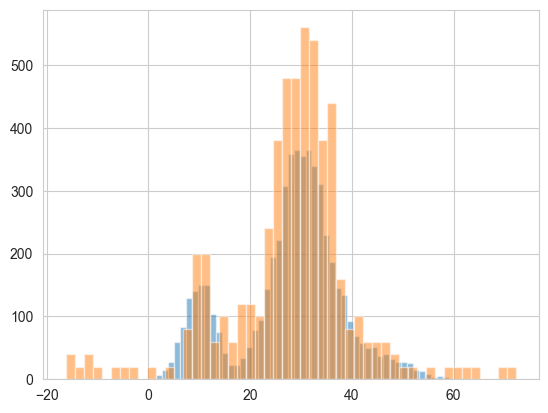

In [968]:
plt.hist(multimodal_dist_target, bins=50, alpha=0.5)
plt.hist(res_p3.x, bins=50, alpha=0.5, weights=np.ones_like(res_p3.x) * 20.0)
plt.show()

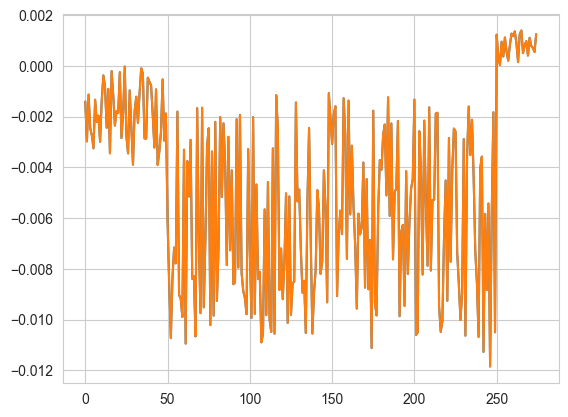

In [983]:
weights = np.abs(np.random.normal(loc=10, size=multimodal_dist_init.size))
# def cost_fun(x) -> float:
#     return cdf_distance(p, x, v, weights, pv) * 1e1


# def cost_fun_grad(x) -> NDArrayFloat:
#     return cdf_distance_gradient(p, x, v, weights, pv) * 1e1

# assert is_gradient_correct(multimodal_dist_init, fm=cost_fun, grad=cost_fun_grad, eps=1e-3)


def cost_fun(x) -> float:
    return cdf_distance(2, x, v, weights, pv) * 10.0


def cost_fun_grad(x) -> NDArrayFloat:
    return cdf_distance_gradient(2, x, v, weights, pv) * 10.0


grad_fd = finite_gradient(multimodal_dist_init, cost_fun, eps=1e-8)
grad_an = cost_fun_grad(multimodal_dist_init)

plt.plot(grad_fd)
plt.plot(grad_an)